In [5]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


In [7]:
import os
import shutil
import zipfile

# ==================== UNZIP DATASET FROM GOOGLE DRIVE ====================

# Define paths
dataset_zip_path = '/content/drive/MyDrive/dataset.zip'  # Change this to your actual zip file path
extract_folder = '/content/betel_dataset'

# Check if dataset exists
if not os.path.exists(dataset_zip_path):
    print(f"❌ Dataset not found at: {dataset_zip_path}")
    print("Please make sure:")
    print("1. Your dataset.zip file is uploaded to Google Drive")
    print("2. Update the path to your actual zip file location")
else:
    print(f"✅ Dataset found at: {dataset_zip_path}")

    # Clean extraction folder if it exists
    if os.path.exists(extract_folder):
        shutil.rmtree(extract_folder)
        print("🧹 Cleaned existing extraction folder")

    # Create extraction folder
    os.makedirs(extract_folder, exist_ok=True)

    # Extract the zip file
    print("📦 Extracting dataset...")
    with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
    print("✅ Dataset extracted successfully!")

    # Check extracted structure
    print("\n📁 Dataset structure:")
    for root, dirs, files in os.walk(extract_folder):
        level = root.replace(extract_folder, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:  # Show first 5 files
            print(f'{subindent}{file}')
        if len(files) > 5:
            print(f'{subindent}... and {len(files) - 5} more files')

✅ Dataset found at: /content/drive/MyDrive/dataset.zip
🧹 Cleaned existing extraction folder
📦 Extracting dataset...
✅ Dataset extracted successfully!

📁 Dataset structure:
betel_dataset/
  dataset/
    Peedunu/
      Peedunu0410.jpg
      Peedunu0475.jpg
      Peedunu0474.jpg
      Peedunu0240.jpg
      Peedunu0257.jpg
      ... and 504 more files
    Korikan/
      Korikani0396.jpg
      Korikani0476.jpg
      Korikani0006.jpg
      Korikani0232.jpg
      Korikani0024.jpg
      ... and 503 more files
    Keti/
      Keti0293.jpg
      Keti0431.jpg
      Keti0205.jpg
      Keti0516.jpg
      Keti0425.jpg
      ... and 494 more files
    Kanda/
      Kandar0036.jpg
      Kandar0084.jpg
      Kandar0070.jpg
      Kandar0042.jpg
      Kandar0009.jpg
      ... and 97 more files


STEP 3: DATA ANALYSIS
✅ Dataset found at: /content/betel_dataset/dataset

📁 Checking folder structure...
dataset/
  Peedunu/
  Korikan/
  Keti/
  Kanda/
  Peedunu/
  Korikan/
  Keti/
  Kanda/

📊 CLASS DISTRIBUTION ANALYSIS
All classes found:
['Peedunu', 'Korikan', 'Keti', 'Kanda']

📊 Analyzing overall dataset (no splits yet):
  Peedunu: 509 images
  Korikan: 508 images
  Keti: 499 images
  Kanda: 102 images


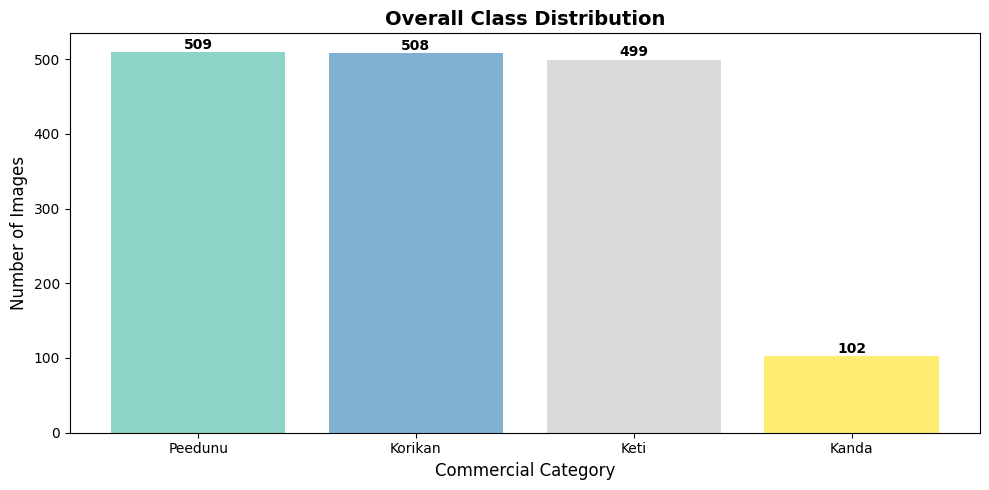


🖼️ IMAGE STATISTICS ANALYSIS

Analyzing all dataset images:
  Analyzed 200 sample images
  Image width range: 2145 - 4032 pixels
  Image height range: 3024 - 4032 pixels
  Average dimensions: 3088 x 3955 pixels
  Aspect ratio range: 0.53 - 1.33
  Most common aspect ratio: 0.75


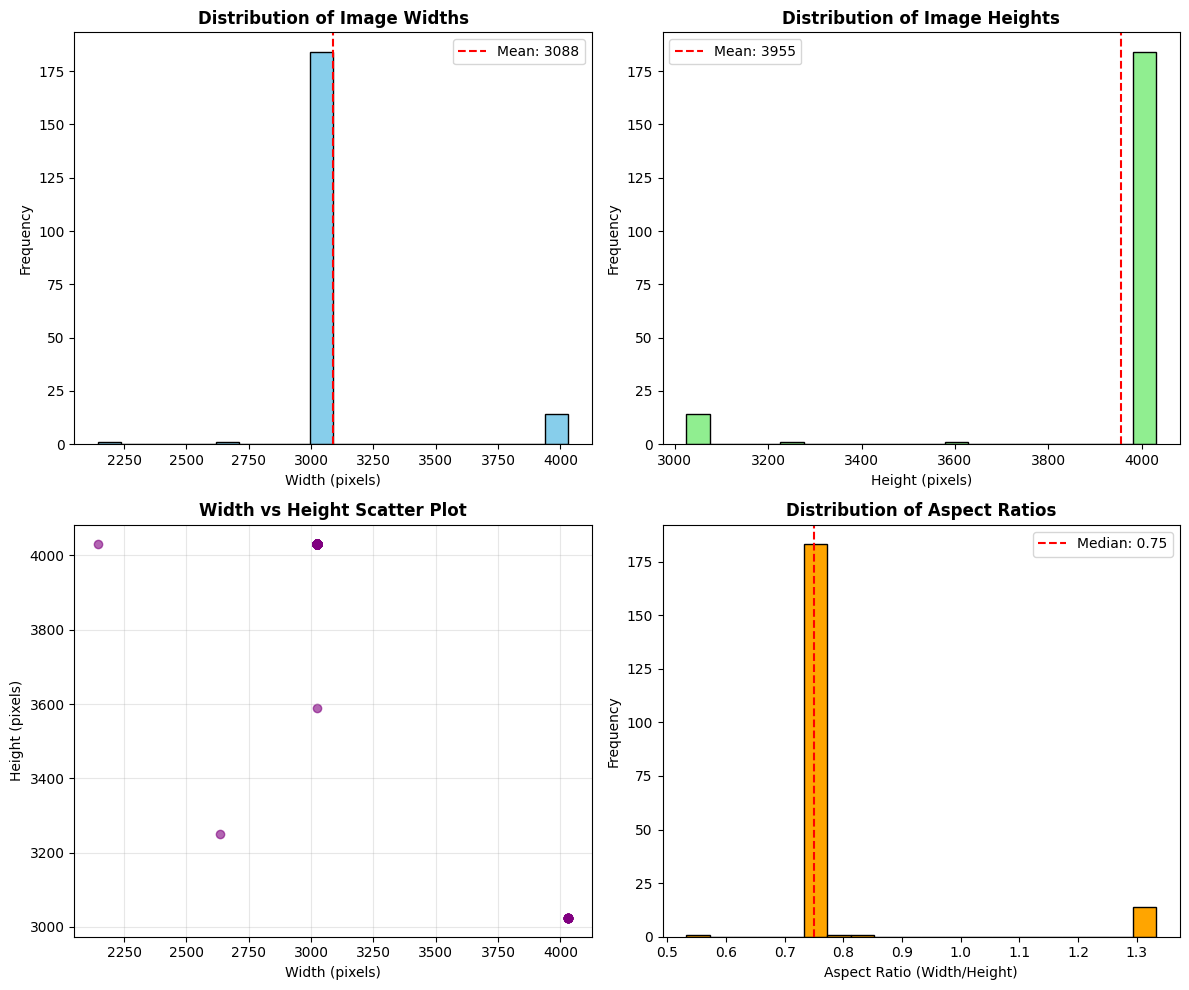


👁️ VISUAL SAMPLE INSPECTION
Displaying sample images from all classes:


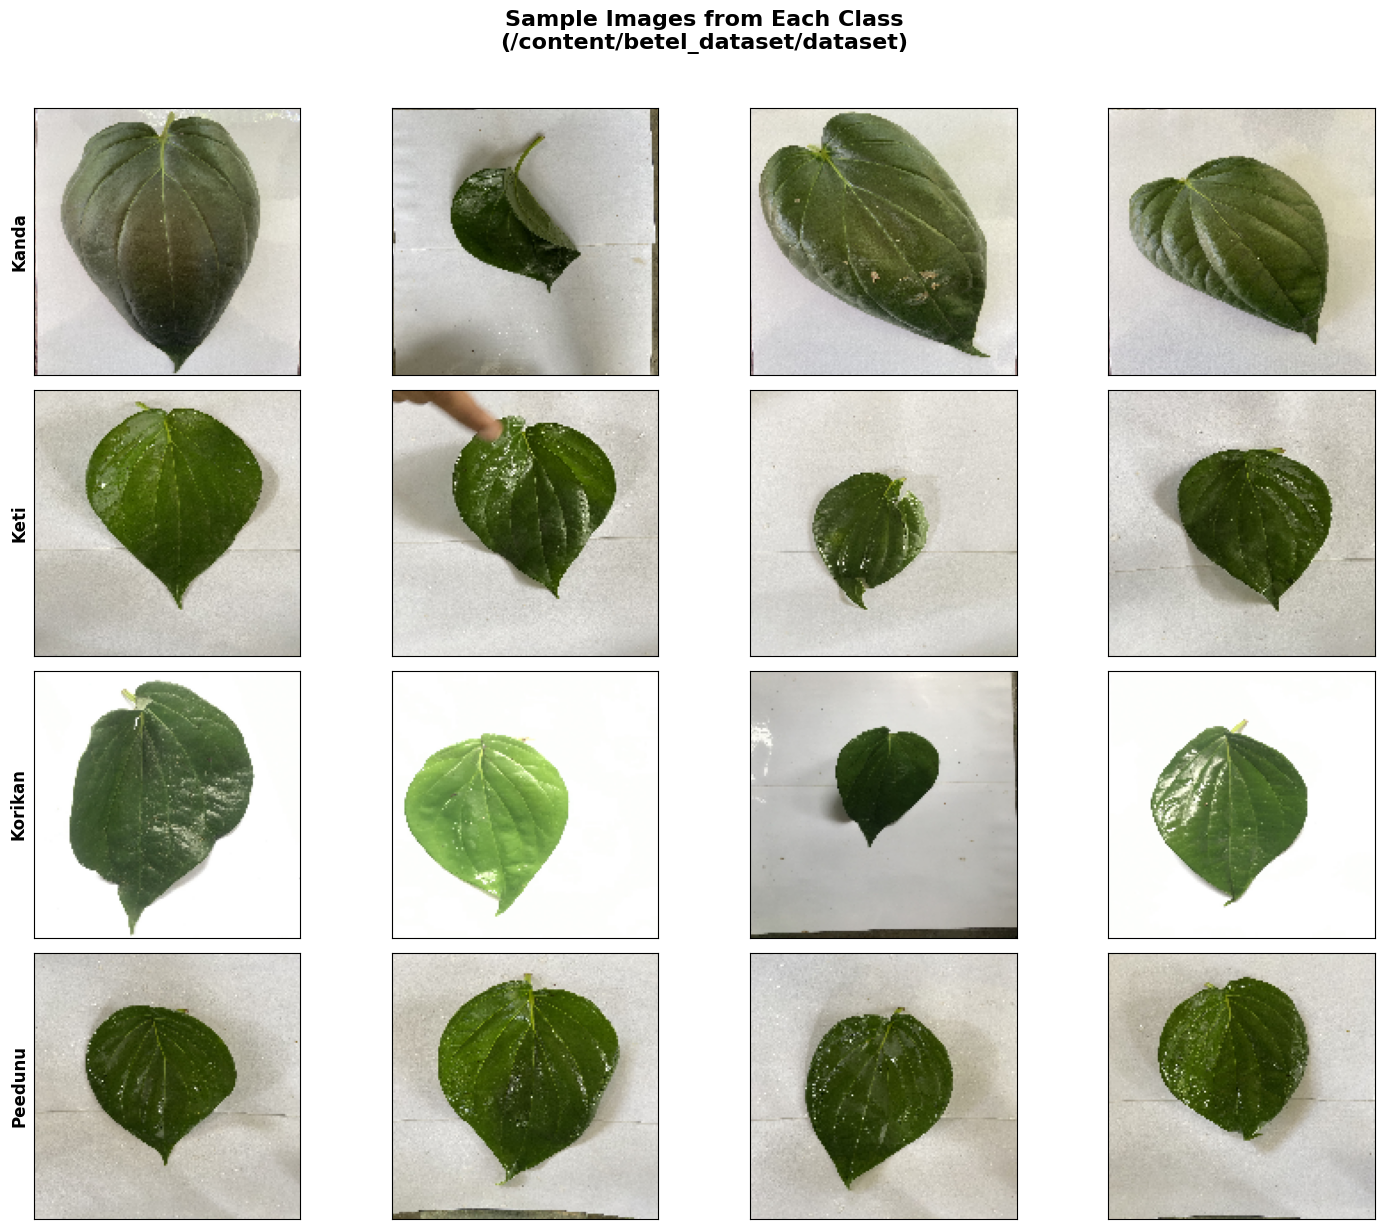


DATA ANALYSIS SUMMARY

📋 DATASET SUMMARY:
  Dataset location: /content/betel_dataset/dataset
  Number of classes: 4
  Classes identified: Peedunu, Korikan, Keti, Kanda
  Has train/val/test splits: No

🎯 RECOMMENDATIONS FOR NEXT STEPS:
  1. Ensure balanced classes (use augmentation if imbalanced)
  2. Resize all images to consistent dimensions (recommended: 224x224 or 128x128)
  3. Apply heavy augmentation to increase dataset variability
  4. Create validation set if not present (15-20% of data)
  5. Keep test set separate for final evaluation

✅ STEP 3 COMPLETE: Data analysis done!
Proceed to STEP 4: Heavy Augmentation


In [8]:
# ==================== STEP 3: DATA ANALYSIS ====================
print("=" * 60)
print("STEP 3: DATA ANALYSIS")
print("=" * 60)

# Add missing imports for Image and random
from PIL import Image
import random

# Define dataset path (assuming your dataset is extracted)
base_path = '/content/betel_dataset'
# Correct the commercial_path to point to the actual dataset directory
commercial_path = os.path.join(base_path, 'dataset') # Corrected path

# Check if dataset exists
if not os.path.exists(commercial_path):
    print(f"❌ Dataset not found at: {commercial_path}")
    print("Please check if the extraction was successful.")
else:
    print(f"✅ Dataset found at: {commercial_path}")

# Check folder structure
print("\n📁 Checking folder structure...")
for root, dirs, files in os.walk(commercial_path, topdown=True):
    level = root.replace(commercial_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    if level == 0:  # Show first level subdirectories
        for dir in dirs:
            print(f'{indent}  {dir}/')

# ==================== 3.1: Check Class Distribution ====================
print("\n📊 CLASS DISTRIBUTION ANALYSIS")

# Function to count images in each class
def analyze_class_distribution(data_path):
    """Analyze and visualize class distribution"""
    classes = []
    counts = []

    for class_name in os.listdir(data_path):
        class_path = os.path.join(data_path, class_name)
        if os.path.isdir(class_path):
            num_images = len([f for f in os.listdir(class_path)
                            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))])
            classes.append(class_name)
            counts.append(num_images)
            print(f"  {class_name}: {num_images} images")

    return classes, counts

# Check all classes in commercial classification
print("All classes found:")
classes = [d for d in os.listdir(commercial_path)
           if os.path.isdir(os.path.join(commercial_path, d))]
print(classes)

# Check if we have pre-split data or need to create splits
has_splits = any(x in os.listdir(commercial_path) for x in ['train', 'val', 'test'])

if has_splits:
    print("\n📊 Dataset already has train/val/test splits")
    # Analyze each split
    for split in ['train', 'val', 'test']:
        split_path = os.path.join(commercial_path, split)
        if os.path.exists(split_path):
            print(f"\n{split.upper()} SET DISTRIBUTION:")
            classes_split, counts_split = analyze_class_distribution(split_path)

            # Create visualization
            plt.figure(figsize=(10, 4))
            bars = plt.bar(classes_split, counts_split, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
            plt.title(f'Class Distribution - {split.capitalize()} Set', fontsize=14, fontweight='bold')
            plt.xlabel('Commercial Category', fontsize=12)
            plt.ylabel('Number of Images', fontsize=12)
            plt.xticks(rotation=45)

            # Add count labels on bars
            for bar, count in zip(bars, counts_split):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                        str(count), ha='center', va='bottom', fontweight='bold')

            plt.tight_layout()
            plt.show()

            # Calculate statistics
            total = sum(counts_split)
            percentages = [(count/total)*100 for count in counts_split]

            print(f"  Total images in {split}: {total}")
            for cls, count, perc in zip(classes_split, counts_split, percentages):
                print(f"    {cls}: {count} images ({perc:.1f}%)")

            # Check for class imbalance
            max_count = max(counts_split)
            min_count = min(counts_split)
            imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

            print(f"  Class imbalance ratio: {imbalance_ratio:.2f}")
            if imbalance_ratio > 3:
                print("  ⚠️  Warning: Significant class imbalance detected!")
                print("  Recommendation: Use class weights or data augmentation")
else:
    print("\n📊 Analyzing overall dataset (no splits yet):")
    classes_all, counts_all = analyze_class_distribution(commercial_path)

    # Visualization
    plt.figure(figsize=(10, 5))
    colors = plt.cm.Set3(np.linspace(0, 1, len(classes_all)))
    bars = plt.bar(classes_all, counts_all, color=colors)
    plt.title('Overall Class Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Commercial Category', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)

    # Add count labels
    for bar, count in zip(bars, counts_all):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                str(count), ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

# ==================== 3.2: Image Statistics Analysis ====================
print("\n🖼️ IMAGE STATISTICS ANALYSIS")

def analyze_image_statistics(data_path, sample_size=50):
    """Analyze image dimensions, aspect ratios, and color statistics"""
    all_images = []
    widths = []
    heights = []
    aspect_ratios = []

    # Collect sample images from each class
    for class_name in os.listdir(data_path):
        class_path = os.path.join(data_path, class_name)
        if os.path.isdir(class_path):
            images = [f for f in os.listdir(class_path)
                     if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

            # Sample images from this class
            sample = random.sample(images, min(sample_size, len(images)))

            for img_name in sample:
                img_path = os.path.join(class_path, img_name)
                try:
                    with Image.open(img_path) as img:
                        width, height = img.size
                        widths.append(width)
                        heights.append(height)
                        aspect_ratios.append(width / height)
                        all_images.append(img_path)
                except Exception as e:
                    print(f"  Could not read {img_name}: {e}")

    # Calculate statistics
    if widths and heights:
        print(f"  Analyzed {len(widths)} sample images")
        print(f"  Image width range: {min(widths)} - {max(widths)} pixels")
        print(f"  Image height range: {min(heights)} - {max(heights)} pixels")
        print(f"  Average dimensions: {np.mean(widths):.0f} x {np.mean(heights):.0f} pixels")
        print(f"  Aspect ratio range: {min(aspect_ratios):.2f} - {max(aspect_ratios):.2f}")
        print(f"  Most common aspect ratio: {np.median(aspect_ratios):.2f}")

        # Create visualizations
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))

        # Distribution of widths
        axes[0, 0].hist(widths, bins=20, color='skyblue', edgecolor='black')
        axes[0, 0].set_title('Distribution of Image Widths', fontweight='bold')
        axes[0, 0].set_xlabel('Width (pixels)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].axvline(np.mean(widths), color='red', linestyle='--', label=f'Mean: {np.mean(widths):.0f}')
        axes[0, 0].legend()

        # Distribution of heights
        axes[0, 1].hist(heights, bins=20, color='lightgreen', edgecolor='black')
        axes[0, 1].set_title('Distribution of Image Heights', fontweight='bold')
        axes[0, 1].set_xlabel('Height (pixels)')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].axvline(np.mean(heights), color='red', linestyle='--', label=f'Mean: {np.mean(heights):.0f}')
        axes[0, 1].legend()

        # Scatter plot of dimensions
        axes[1, 0].scatter(widths, heights, alpha=0.6, color='purple')
        axes[1, 0].set_title('Width vs Height Scatter Plot', fontweight='bold')
        axes[1, 0].set_xlabel('Width (pixels)')
        axes[1, 0].set_ylabel('Height (pixels)')
        axes[1, 0].grid(True, alpha=0.3)

        # Aspect ratio distribution
        axes[1, 1].hist(aspect_ratios, bins=20, color='orange', edgecolor='black')
        axes[1, 1].set_title('Distribution of Aspect Ratios', fontweight='bold')
        axes[1, 1].set_xlabel('Aspect Ratio (Width/Height)')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].axvline(np.median(aspect_ratios), color='red', linestyle='--',
                          label=f'Median: {np.median(aspect_ratios):.2f}')
        axes[1, 1].legend()

        plt.tight_layout()
        plt.show()

        return widths, heights, aspect_ratios
    else:
        print("  No images found to analyze")
        return None, None, None

# Analyze images from the dataset
if has_splits:
    # Analyze training set if splits exist
    train_path = os.path.join(commercial_path, 'train')
    if os.path.exists(train_path):
        print("\nAnalyzing training set images:")
        widths, heights, aspect_ratios = analyze_image_statistics(train_path)
else:
    # Analyze all images if no splits
    print("\nAnalyzing all dataset images:")
    widths, heights, aspect_ratios = analyze_image_statistics(commercial_path)

# ==================== 3.3: Visualize Sample Images ====================
print("\n👁️ VISUAL SAMPLE INSPECTION")

def display_sample_images(data_path, num_samples=5):
    """Display sample images from each class"""
    classes = sorted([d for d in os.listdir(data_path)
                     if os.path.isdir(os.path.join(data_path, d))])

    if not classes:
        print("  No classes found!")
        return

    # Create figure
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 3*len(classes)))

    if len(classes) == 1:
        axes = [axes]

    for i, class_name in enumerate(classes):
        class_path = os.path.join(data_path, class_name)
        images = [f for f in os.listdir(class_path)
                 if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

        if not images:
            print(f"  No images found in {class_name}")
            continue

        # Randomly select samples
        sample_images = random.sample(images, min(num_samples, len(images)))

        for j, img_name in enumerate(sample_images):
            img_path = os.path.join(class_path, img_name)
            try:
                img = keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
                if len(classes) > 1:
                    axes[i, j].imshow(img)
                    if j == 0:
                        axes[i, j].set_ylabel(class_name, fontsize=12, fontweight='bold')
                    axes[i, j].set_xticks([])
                    axes[i, j].set_yticks([])
                else:
                    axes[j].imshow(img)
                    axes[j].set_xticks([])
                    axes[j].set_yticks([])
            except Exception as e:
                print(f"  Could not display {img_name}: {e}")

    plt.suptitle(f'Sample Images from Each Class\n({data_path})',
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Display samples
if has_splits:
    # Show training samples
    train_path = os.path.join(commercial_path, 'train')
    if os.path.exists(train_path):
        print("Displaying sample images from training set:")
        display_sample_images(train_path, num_samples=4)
else:
    # Show all samples
    print("Displaying sample images from all classes:")
    display_sample_images(commercial_path, num_samples=4)

# ==================== 3.4: Summary Report ====================
print("\n" + "=" * 60)
print("DATA ANALYSIS SUMMARY")
print("=" * 60)

print("\n📋 DATASET SUMMARY:")
print(f"  Dataset location: {commercial_path}")
print(f"  Number of classes: {len(classes)}")
print(f"  Classes identified: {', '.join(classes)}")
print(f"  Has train/val/test splits: {'Yes' if has_splits else 'No'}")

if has_splits:
    # Calculate totals for each split
    total_train = total_val = total_test = 0

    for split in ['train', 'val', 'test']:
        split_path = os.path.join(commercial_path, split)
        if os.path.exists(split_path):
            split_total = 0
            for cls in os.listdir(split_path):
                cls_path = os.path.join(split_path, cls)
                if os.path.isdir(cls_path):
                    split_total += len([f for f in os.listdir(cls_path)
                                       if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))])

            if split == 'train':
                total_train = split_total
            elif split == 'val':
                total_val = split_total
            elif split == 'test':
                total_test = split_total

    total_all = total_train + total_val + total_test

    print(f"\n📊 SPLIT STATISTICS:")
    print(f"  Total images: {total_all}")
    print(f"  Training set: {total_train} images ({total_train/total_all*100:.1f}%)")
    print(f"  Validation set: {total_val} images ({total_val/total_all*100:.1f}%)")
    print(f"  Test set: {total_test} images ({total_test/total_all*100:.1f}%)")

    if total_val == 0:
        print("  ⚠️  Warning: No validation set found!")
    if total_test == 0:
        print("  ⚠️  Warning: No test set found!")

print("\n🎯 RECOMMENDATIONS FOR NEXT STEPS:")
print("  1. Ensure balanced classes (use augmentation if imbalanced)")
print("  2. Resize all images to consistent dimensions (recommended: 224x224 or 128x128)")
print("  3. Apply heavy augmentation to increase dataset variability")
print("  4. Create validation set if not present (15-20% of data)")
print("  5. Keep test set separate for final evaluation")

print("\n✅ STEP 3 COMPLETE: Data analysis done!")
print("Proceed to STEP 4: Heavy Augmentation")


STEP 4: HEAVY AUGMENTATION
✅ Setting up data augmentation...

📁 Creating train/val/test splits...
✅ Splits created successfully!

📂 Dataset paths:
  Training: /content/betel_dataset/commercial_classification/train
  Validation: /content/betel_dataset/commercial_classification/val
  Test: /content/betel_dataset/commercial_classification/test

⚙️ Creating heavy augmentation configuration...
✅ Augmentation configurations created!

🎯 TRAINING AUGMENTATIONS APPLIED:
  ✓ Rotation (±40°)
  ✓ Width/Height shift (±30%)
  ✓ Shear transformation
  ✓ Zoom (±30%)
  ✓ Brightness adjustment
  ✓ Color channel shift
  ✓ Horizontal & Vertical flip
  ✓ Pixel rescaling (1/255)

👁️ VISUALIZING AUGMENTATIONS

Sample image from class 'Peedunu':


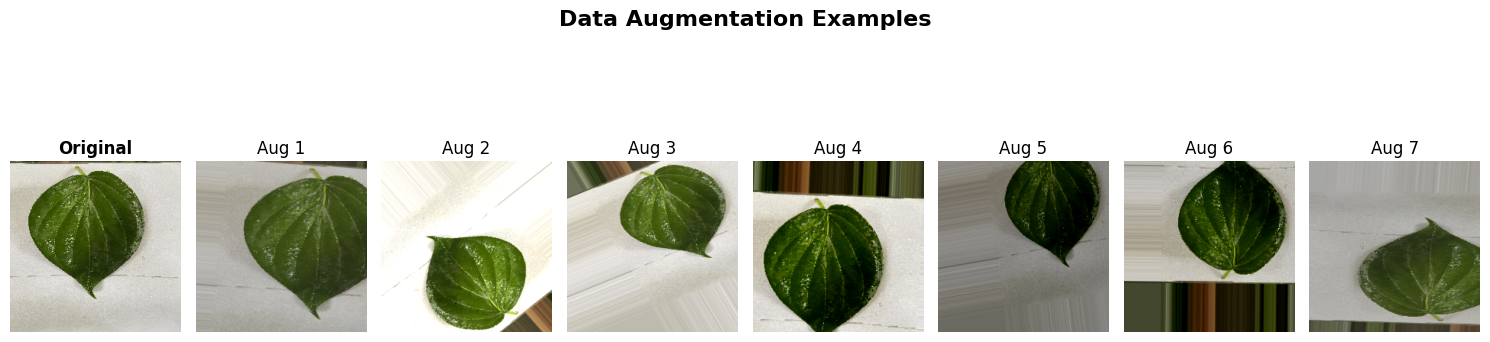


📊 Creating data generators...
  Image size: (224, 224)
  Batch size: 32
  Random seed: 42

🔄 Generating training data...
Found 1131 images belonging to 4 classes.

🔄 Generating validation data...
Found 241 images belonging to 4 classes.

🔄 Generating test data...
Found 246 images belonging to 4 classes.

📋 CLASS MAPPING:
  Kanda → 0
  Keti → 1
  Korikan → 2
  Peedunu → 3

📈 FINAL DATASET STATISTICS

  Total images: 1618
  Training images: 1131 (69.9%)
  Validation images: 241 (14.9%)
  Test images: 246 (15.2%)

  Training batches: 36
  Validation batches: 8
  Test batches: 8

👀 Displaying sample batch from training generator...
  Batch X shape: (32, 224, 224, 3)
  Batch Y shape: (32, 4)

🖼️ Visualizing a batch of augmented training images...


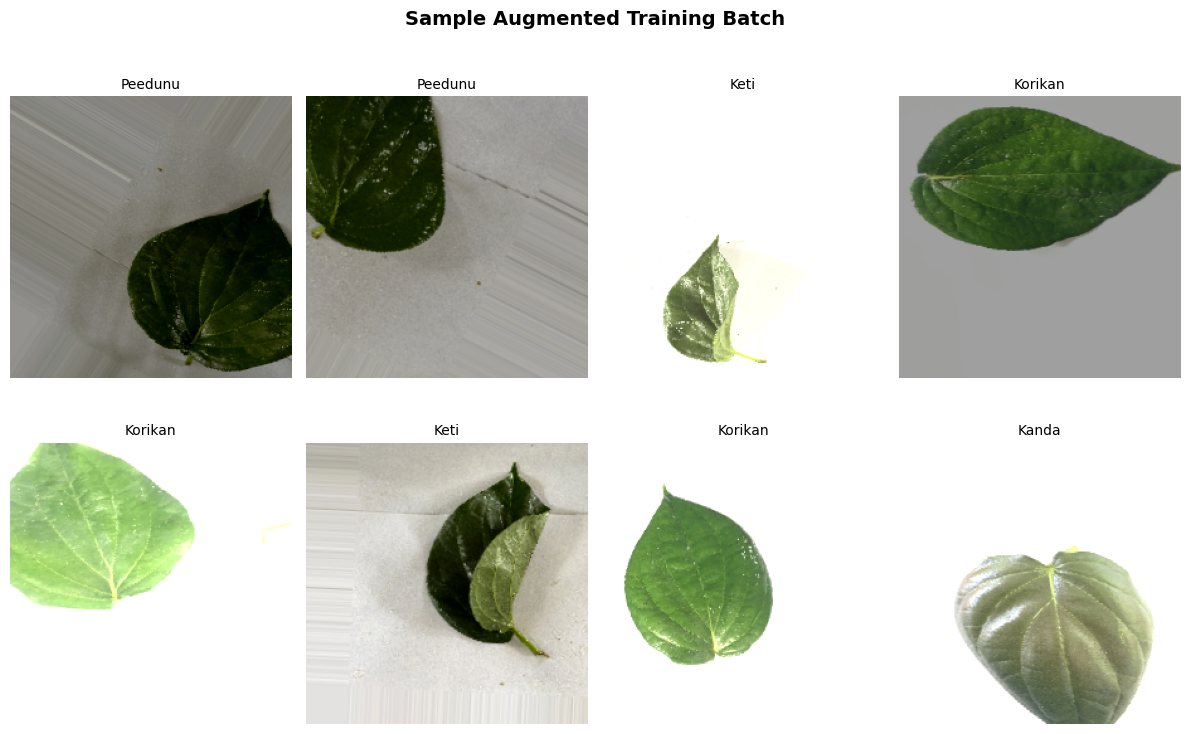


⚖️ CHECKING CLASS BALANCE

📊 Class distribution in training set:
  Peedunu: 356 images (31.5%)
  Korikan: 355 images (31.4%)
  Keti: 349 images (30.9%)
  Kanda: 71 images (6.3%)

⚖️ Calculating class weights...
  Peedunu: weight = 0.79
  Korikan: weight = 0.80
  Keti: weight = 0.81
  Kanda: weight = 3.98

🎯 AUGMENTATION STRATEGY SUMMARY:
  1. Heavy geometric transformations (rotation, shift, shear, zoom)
  2. Color space augmentations (brightness, channel shift)
  3. Flipping in both directions
  4. Class weights applied for imbalance handling
  5. Validation/Test sets use only rescaling (no augmentation)

✅ STEP 4 COMPLETE: Heavy augmentation setup complete!
Proceed to STEP 5: Model Building


In [10]:
## ==================== STEP 4: HEAVY AUGMENTATION ====================
print("\n" + "=" * 60)
print("STEP 4: HEAVY AUGMENTATION")
print("=" * 60)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import shutil # Added for file operations

print("✅ Setting up data augmentation...")

# Define paths
base_path = '/content/betel_dataset'
source_data_path = os.path.join(base_path, 'dataset') # This is where the original class folders are
processed_data_root = os.path.join(base_path, 'commercial_classification') # This is where the splits will be created

# Ensure the processed_data_root exists
os.makedirs(processed_data_root, exist_ok=True)

# Check if we need to create splits
# We check for 'train', 'val', 'test' folders inside the processed_data_root
has_splits = any(x in os.listdir(processed_data_root) for x in ['train', 'val', 'test']) and \
             os.path.isdir(os.path.join(processed_data_root, 'train')) # check if it's actually a directory

if not has_splits:
    print("\n📁 Creating train/val/test splits...")

    # Create directories for splits
    splits = ['train', 'val', 'test']
    for split in splits:
        split_dir = os.path.join(processed_data_root, split)
        os.makedirs(split_dir, exist_ok=True)
        # Iterate over original classes in source_data_path to create subdirectories in splits
        for cls in os.listdir(source_data_path):
            cls_source_path = os.path.join(source_data_path, cls)
            if os.path.isdir(cls_source_path):
                os.makedirs(os.path.join(split_dir, cls), exist_ok=True)

    # Split data (70% train, 15% val, 15% test)
    for cls in os.listdir(source_data_path):
        cls_source_path = os.path.join(source_data_path, cls)
        if os.path.isdir(cls_source_path):
            images = [f for f in os.listdir(cls_source_path)
                     if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
            random.shuffle(images)

            n_total = len(images)
            n_train = int(n_total * 0.7)
            n_val = int(n_total * 0.15)

            train_images = images[:n_train]
            val_images = images[n_train:n_train + n_val]
            test_images = images[n_train + n_val:]

            # Copy images to respective directories
            for img in train_images:
                src = os.path.join(cls_source_path, img)
                dst = os.path.join(processed_data_root, 'train', cls, img)
                if os.path.exists(src):
                    shutil.copy(src, dst) # Use shutil.copy for direct file copy

            for img in val_images:
                src = os.path.join(cls_source_path, img)
                dst = os.path.join(processed_data_root, 'val', cls, img)
                if os.path.exists(src):
                    shutil.copy(src, dst)

            for img in test_images:
                src = os.path.join(cls_source_path, img)
                dst = os.path.join(processed_data_root, 'test', cls, img)
                if os.path.exists(src):
                    shutil.copy(src, dst)

    print("✅ Splits created successfully!")

# Define paths for each split (now based on processed_data_root)
train_dir = os.path.join(processed_data_root, 'train')
val_dir = os.path.join(processed_data_root, 'val')
test_dir = os.path.join(processed_data_root, 'test')

print(f"\n📂 Dataset paths:")
print(f"  Training: {train_dir}")
print(f"  Validation: {val_dir}")
print(f"  Test: {test_dir}")

# ==================== 4.1: Define HEAVY AUGMENTATION ====================
print("\n⚙️ Creating heavy augmentation configuration...")

# HEAVY AUGMENTATION for training data
train_datagen = ImageDataGenerator(
    # Basic augmentations
    rotation_range=40,            # Rotate images by up to 40 degrees
    width_shift_range=0.3,        # Shift width by up to 30%
    height_shift_range=0.3,       # Shift height by up to 30%

    # Advanced geometric augmentations
    shear_range=0.3,              # Shear transformations
    zoom_range=0.3,               # Zoom in/out by up to 30%

    # Brightness and contrast
    brightness_range=[0.7, 1.3],  # Adjust brightness
    channel_shift_range=50.0,     # Shift color channels

    # Color augmentations
    horizontal_flip=True,         # Flip horizontally
    vertical_flip=True,           # Flip vertically

    # Fill mode for newly created pixels
    fill_mode='nearest',

    # Rescaling (important for CNN)
    rescale=1./255
)

# Validation and test data - NO AUGMENTATION, only rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

print("✅ Augmentation configurations created!")
print("\n🎯 TRAINING AUGMENTATIONS APPLIED:")
print("  ✓ Rotation (±40°)")
print("  ✓ Width/Height shift (±30%)")
print("  ✓ Shear transformation")
print("  ✓ Zoom (±30%)")
print("  ✓ Brightness adjustment")
print("  ✓ Color channel shift")
print("  ✓ Horizontal & Vertical flip")
print("  ✓ Pixel rescaling (1/255)")

# ==================== 4.2: Visualize Augmentations ====================
print("\n👁️ VISUALIZING AUGMENTATIONS")

def visualize_augmentations(image_path, datagen, num_augmented=8):
    """Visualize augmented versions of a sample image"""
    # Load a sample image
    img = keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Create figure
    plt.figure(figsize=(15, 4))

    # Show original image
    plt.subplot(1, num_augmented + 1, 1)
    plt.imshow(img)
    plt.title('Original', fontweight='bold')
    plt.axis('off')

    # Show augmented images
    i = 0
    for batch in datagen.flow(img_array, batch_size=1):
        plt.subplot(1, num_augmented + 1, i + 2)
        plt.imshow(batch[0])
        plt.title(f'Aug {i+1}')
        plt.axis('off')

        i += 1
        if i >= num_augmented:
            break

    plt.suptitle('Data Augmentation Examples', fontsize=16, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()

# Find a sample image to visualize augmentations
sample_found = False
if os.path.exists(train_dir):
    for cls in os.listdir(train_dir):
        cls_path = os.path.join(train_dir, cls)
        if os.path.isdir(cls_path):
            images = [f for f in os.listdir(cls_path)
                     if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
            if images:
                sample_image_path = os.path.join(cls_path, images[0])
                print(f"\nSample image from class '{cls}':")
                visualize_augmentations(sample_image_path, train_datagen, num_augmented=7)
                sample_found = True
                break

if not sample_found:
    print("❌ No sample image found for visualization")

# ==================== 4.3: Create Data Generators ====================
print("\n📊 Creating data generators...")

# Image parameters
IMG_SIZE = (224, 224)  # Standard size for many CNN models
BATCH_SIZE = 32
SEED = 42

print(f"  Image size: {IMG_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Random seed: {SEED}")

# Create data generators
print("\n🔄 Generating training data...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

print("\n🔄 Generating validation data...")
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  # Don't shuffle validation data
    seed=SEED
)

print("\n🔄 Generating test data...")
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  # Don't shuffle test data
    seed=SEED
)

# Print class indices
print(f"\n📋 CLASS MAPPING:")
class_indices = train_generator.class_indices
for class_name, index in class_indices.items():
    print(f"  {class_name} → {index}")

# ==================== 4.4: Dataset Statistics ====================
print("\n📈 FINAL DATASET STATISTICS")

# Count images in each set
def count_images(directory):
    total = 0
    if os.path.exists(directory):
        for cls in os.listdir(directory):
            cls_path = os.path.join(directory, cls)
            if os.path.isdir(cls_path):
                total += len([f for f in os.listdir(cls_path)
                             if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))])
    return total

train_count = count_images(train_dir)
val_count = count_images(val_dir)
test_count = count_images(test_dir)
total_count = train_count + val_count + test_count

print(f"\n  Total images: {total_count}")
print(f"  Training images: {train_count} ({train_count/total_count*100:.1f}%)")
print(f"  Validation images: {val_count} ({val_count/total_count*100:.1f}%)")
print(f"  Test images: {test_count} ({test_count/total_count*100:.1f}%)")

# Check batch sizes
num_train_batches = len(train_generator) if train_generator.samples > 0 else 0
num_val_batches = len(val_generator) if val_generator.samples > 0 else 0
num_test_batches = len(test_generator) if test_generator.samples > 0 else 0

print(f"\n  Training batches: {num_train_batches}")
print(f"  Validation batches: {num_val_batches}")
print(f"  Test batches: {num_test_batches}")

# Display sample batch
if train_generator.samples > 0:
    print("\n👀 Displaying sample batch from training generator...")
    sample_batch_x, sample_batch_y = next(train_generator)
    print(f"  Batch X shape: {sample_batch_x.shape}")  # Should be (batch_size, height, width, channels)
    print(f"  Batch Y shape: {sample_batch_y.shape}")  # Should be (batch_size, num_classes)

    # Visualize a batch of augmented images
    print("\n🖼️ Visualizing a batch of augmented training images...")
    plt.figure(figsize=(12, 8))
    for i in range(min(8, BATCH_SIZE)):
        plt.subplot(2, 4, i+1)
        plt.imshow(sample_batch_x[i])
        # Get class label
        class_idx = np.argmax(sample_batch_y[i])
        class_name = list(class_indices.keys())[list(class_indices.values()).index(class_idx)]
        plt.title(f'{class_name}', fontsize=10)
        plt.axis('off')
    plt.suptitle('Sample Augmented Training Batch', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("\n❌ No training samples found to display a batch.")

# ==================== 4.5: Check for Class Imbalance ====================
print("\n⚖️ CHECKING CLASS BALANCE")

def get_class_counts(directory):
    """Get count of images per class in a directory"""
    class_counts = {}
    if os.path.exists(directory):
        for cls in os.listdir(directory):
            cls_path = os.path.join(directory, cls)
            if os.path.isdir(cls_path):
                count = len([f for f in os.listdir(cls_path)
                            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))])
                class_counts[cls] = count
    return class_counts

train_counts = get_class_counts(train_dir)
val_counts = get_class_counts(val_dir)
test_counts = get_class_counts(test_dir)

if train_count > 0:
    print("\n📊 Class distribution in training set:")
    for cls, count in train_counts.items():
        percentage = (count / train_count) * 100
        print(f"  {cls}: {count} images ({percentage:.1f}%)")

    # Calculate class weights for handling imbalance
    print("\n⚖️ Calculating class weights...")
    total_samples = sum(train_counts.values())
    class_weights = {}
    if len(train_counts) > 0:
        for cls, count in train_counts.items():
            # Weight is inversely proportional to class frequency
            weight = total_samples / (len(train_counts) * count)
            # Ensure class_indices is populated, check if 'train_generator.class_indices' exists
            if train_generator.class_indices and cls in train_generator.class_indices:
                class_weights[train_generator.class_indices[cls]] = weight
                print(f"  {cls}: weight = {weight:.2f}")
            else:
                print(f"  Warning: Class {cls} not found in training generator class indices.")
    else:
        print("  No classes found in training set to calculate weights.")
else:
    print("\n❌ No training samples found to analyze class distribution or calculate weights.")

print("\n🎯 AUGMENTATION STRATEGY SUMMARY:")
print("  1. Heavy geometric transformations (rotation, shift, shear, zoom)")
print("  2. Color space augmentations (brightness, channel shift)")
print("  3. Flipping in both directions")
print("  4. Class weights applied for imbalance handling")
print("  5. Validation/Test sets use only rescaling (no augmentation)")

print("\n✅ STEP 4 COMPLETE: Heavy augmentation setup complete!")
print("Proceed to STEP 5: Model Building")


STEP 5 & 6: MODEL BUILDING & TRAINING
✅ Loading libraries for model building...

🏗️ BUILDING CUSTOM CNN MODEL
  Input shape: (224, 224, 3)
  Number of classes: 4

📐 MODEL ARCHITECTURE:


Model: "BetelLeaf_Commercial_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 224, 224, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 224, 224, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 112, 112, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 112, 112, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv2D)                  │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn5 (BatchNormalization)        │ (None, 56, 56, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv6 (Conv2D)                  │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn6 (BatchNormalization)        │ (None, 56, 56, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop3 (Dropout)                 │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv7 (Conv2D)                  │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn7 (BatchNormalization)        │ (None, 28, 28, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv8 (Conv2D)                  │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn8 (BatchNormalization)        │ (None, 28, 28, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop4 (Dropout)                 │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             

 Total params: 27,002,148 (103.01 MB)

 Trainable params: 26,998,692 (102.99 MB)

 Non-trainable params: 3,456 (13.50 KB)


⚙️ COMPILING MODEL...
✅ Model compiled successfully!
  Optimizer: Adam (learning_rate=0.001)
  Loss function: Categorical Crossentropy
  Metrics: Accuracy

🔔 SETTING UP CALLBACKS...
✅ Callbacks configured:
  1. EarlyStopping: Patience=15, Monitor=val_loss
  2. ModelCheckpoint: Save best model to /content/saved_models/
  3. CSVLogger: Training log saved

STEP 6: TRAINING THE MODEL

🚀 STARTING TRAINING FOR 50 EPOCHS...
  Note: Training will stop early if no improvement for 15 epochs
  Initial Learning Rate: 0.0010000000474974513
  Using class weights: Yes

--------------------------------------------------------------------------------
TRAINING STARTED:
--------------------------------------------------------------------------------
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3298 - loss: 2.1754
Epoch 1: val_loss improved from inf to 2.55226, saving model to /content/saved_models/best_model_20251215_063832.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 0.3308 - loss: 2.1718 - val_accuracy: 0.3071 - val_loss: 2.5523
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4582 - loss: 1.8162
Epoch 2: val_loss did not improve from 2.55226
36/36 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.4583 - loss: 1.8128 - val_accuracy: 0.3071 - val_loss: 3.7541
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5491 - loss: 1.4158
Epoch 3: val_loss improved from 2.55226 to 2.23797, saving model to /content/saved_models/best_model_20251215_063832.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.5491 - loss: 1.4142 - val_accuracy: 0.3071 - val_loss: 2.2380
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5390 - loss: 1.5113
Epoch 4: val_loss did not improve from 2.23797
36/36 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.5394 - loss: 1.5055 - val_accuracy: 0.3071 - val_loss: 4.6674
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6040 - loss: 1.0758
Epoch 5: val_loss did not improve from 2.23797
36/36 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.6041 - loss: 1.0738 - val_accuracy: 0.3071 - val_loss: 3.7124
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6112 - loss: 1.0938
Epoch 6: val_loss did not improve from 2.23797
36/36 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.6117 - loss: 1.0909 - val_accuracy: 0.3237 - val_loss: 3.1338
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6268 - loss: 0.9618
Epoch 7: val_loss improved from 2.23797 to 1.35007, saving mode

36/36 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.6270 - loss: 0.9627 - val_accuracy: 0.4606 - val_loss: 1.3501
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6109 - loss: 1.0322
Epoch 8: val_loss improved from 1.35007 to 1.27157, saving model to /content/saved_models/best_model_20251215_063832.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.6115 - loss: 1.0286 - val_accuracy: 0.5726 - val_loss: 1.2716
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6874 - loss: 0.8397
Epoch 9: val_loss did not improve from 1.27157
36/36 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.6871 - loss: 0.8384 - val_accuracy: 0.3320 - val_loss: 2.8396
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6586 - loss: 0.8193
Epoch 10: val_loss did not improve from 1.27157
36/36 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.6585 - loss: 0.8190 - val_accuracy: 0.3154 - val_loss: 2.5214
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6977 - loss: 0.6767
Epoch 11: val_loss did not improve from 1.27157
36/36 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.6979 - loss: 0.6783 - val_accuracy: 0.3900 - val_loss: 1.7155
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6385 - loss: 0.8800
Epoch 12: val_loss did not improve from 1.27157
36/36 ━━━━━

36/36 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.7343 - loss: 0.6098 - val_accuracy: 0.4689 - val_loss: 1.1805
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7367 - loss: 0.5939
Epoch 15: val_loss did not improve from 1.18049
36/36 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.7360 - loss: 0.5961 - val_accuracy: 0.3485 - val_loss: 5.5606
Epoch 16/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6807 - loss: 0.7733
Epoch 16: val_loss did not improve from 1.18049
36/36 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.6806 - loss: 0.7724 - val_accuracy: 0.3485 - val_loss: 3.6855
Epoch 17/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7518 - loss: 0.7610
Epoch 17: val_loss did not improve from 1.18049
36/36 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.7512 - loss: 0.7600 - val_accuracy: 0.3154 - val_loss: 8.5416
Epoch 18/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7367 - loss: 0.6111
Epoch 18: val_loss did not improve from 1.18049
36/36 ━━━━━

36/36 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.7340 - loss: 0.5854 - val_accuracy: 0.6598 - val_loss: 0.9194
Epoch 26/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7500 - loss: 0.5960
Epoch 26: val_loss did not improve from 0.91938
36/36 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.7501 - loss: 0.5964 - val_accuracy: 0.3278 - val_loss: 3.3811
Epoch 27/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7480 - loss: 0.5875
Epoch 27: val_loss did not improve from 0.91938
36/36 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.7479 - loss: 0.5874 - val_accuracy: 0.3112 - val_loss: 2.9239
Epoch 28/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7769 - loss: 0.5772
Epoch 28: val_loss did not improve from 0.91938
36/36 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.7770 - loss: 0.5762 - val_accuracy: 0.3154 - val_loss: 11.8625
Epoch 29/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7492 - loss: 0.5438
Epoch 29: val_loss did not improve from 0.91938
36/36 ━

36/36 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.7293 - loss: 0.6771 - val_accuracy: 0.7220 - val_loss: 0.6171
Epoch 31/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7533 - loss: 0.5444
Epoch 31: val_loss did not improve from 0.61709
36/36 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.7537 - loss: 0.5444 - val_accuracy: 0.6598 - val_loss: 0.7292
Epoch 32/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7561 - loss: 0.4784
Epoch 32: val_loss did not improve from 0.61709
36/36 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.7566 - loss: 0.4789 - val_accuracy: 0.1452 - val_loss: 5.8226
Epoch 33/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7886 - loss: 0.4374
Epoch 33: val_loss did not improve from 0.61709
36/36 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.7882 - loss: 0.4391 - val_accuracy: 0.5975 - val_loss: 0.9902
Epoch 34/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7693 - loss: 0.4307
Epoch 34: val_loss did not improve from 0.61709
36/36 ━━━━

36/36 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.7319 - loss: 0.5281 - val_accuracy: 0.8091 - val_loss: 0.4549
Epoch 45/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8069 - loss: 0.4373
Epoch 45: val_loss did not improve from 0.45493
36/36 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.8062 - loss: 0.4380 - val_accuracy: 0.7676 - val_loss: 0.5806
Epoch 46/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7817 - loss: 0.4668
Epoch 46: val_loss did not improve from 0.45493
36/36 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.7820 - loss: 0.4680 - val_accuracy: 0.6515 - val_loss: 0.8740
Epoch 47/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7875 - loss: 0.5405
Epoch 47: val_loss did not improve from 0.45493
36/36 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.7874 - loss: 0.5404 - val_accuracy: 0.4896 - val_loss: 2.1535
Epoch 48/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7568 - loss: 0.5652
Epoch 48: val_loss did not improve from 0.45493
36/36 ━━━━

36/36 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.7737 - loss: 0.4582 - val_accuracy: 0.8216 - val_loss: 0.4437
Epoch 50/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7789 - loss: 0.5045
Epoch 50: val_loss did not improve from 0.44369
36/36 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.7787 - loss: 0.5042 - val_accuracy: 0.6763 - val_loss: 0.7270
Restoring model weights from the end of the best epoch: 49.
--------------------------------------------------------------------------------
✅ Training completed!

📈 TRAINING RESULTS:

📊 Training Accuracy: 0.7728 (77.28%)
📊 Validation Accuracy: 0.6763 (67.63%)
📉 Training Loss: 0.4952
📉 Validation Loss: 0.7270
🏆 Best Validation Accuracy: 0.8216 (82.16%) at Epoch 49

📈 VISUALIZING TRAINING HISTORY...


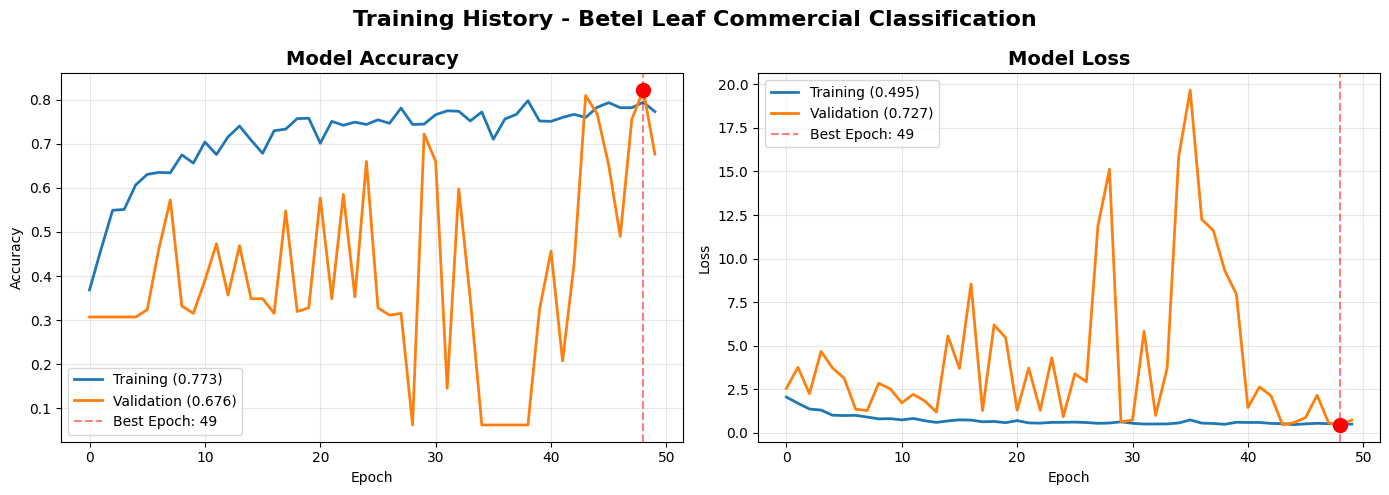


🧪 EVALUATING ON TEST SET...

Evaluating model on test set...
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8411 - loss: 0.3452

📊 TEST SET PERFORMANCE:
  Test Loss: 0.4307
  Test Accuracy: 0.7886

🎯 FINAL TEST ACCURACY: 78.86%

📋 GENERATING PREDICTIONS AND CONFUSION MATRIX...

Generating predictions...

📄 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       Kanda     0.7273    1.0000    0.8421        16
        Keti     0.6436    0.8553    0.7345        76
     Korikan     1.0000    0.9221    0.9595        77
     Peedunu     0.8077    0.5455    0.6512        77

    accuracy                         0.7886       246
   macro avg     0.7946    0.8307    0.7968       246
weighted avg     0.8119    0.7886    0.7858       246



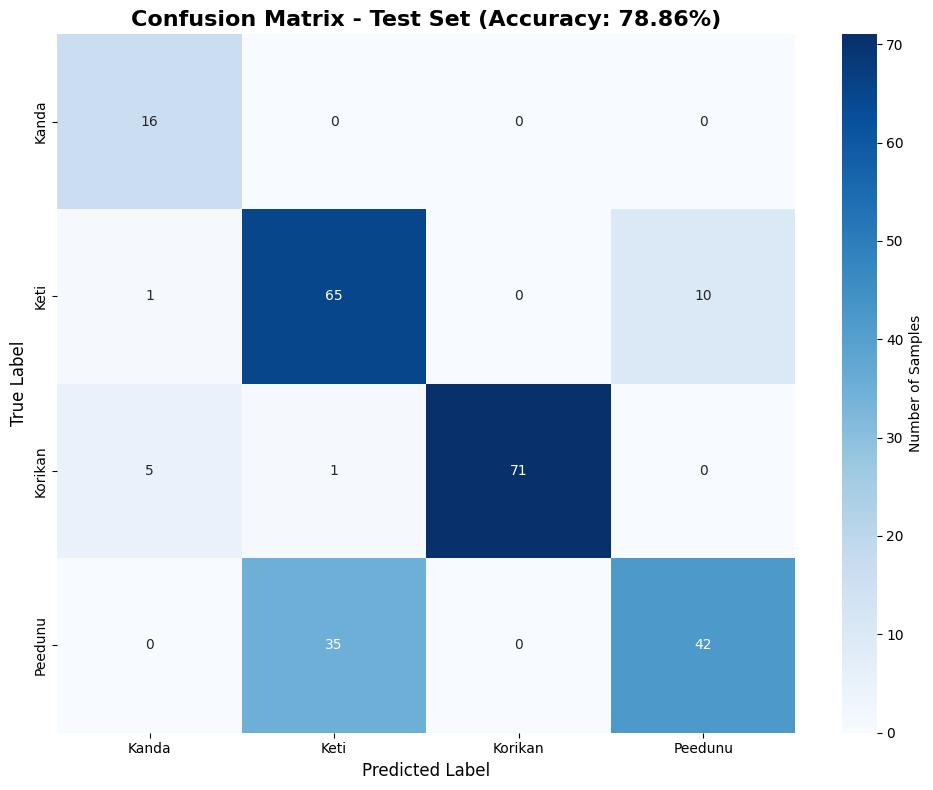


📊 PER-CLASS ACCURACY:
  Kanda: 16/16 = 1.0000 (100.0%)
  Keti: 65/76 = 0.8553 (85.5%)
  Korikan: 71/77 = 0.9221 (92.2%)
  Peedunu: 42/77 = 0.5455 (54.5%)

💾 SAVING FINAL MODEL...
✅ Final model saved to: /content/saved_models/final_model_20251215_063832.h5
✅ Model architecture saved as JSON
✅ Class indices saved

TRAINING COMPLETE - SUMMARY REPORT

🎯 ACCURACY SUMMARY:
  Training Accuracy: 0.7728 (77.28%)
  Validation Accuracy: 0.6763 (67.63%)
  Test Accuracy: 0.7886 (78.86%)

📉 LOSS SUMMARY:
  Training Loss: 0.4952
  Validation Loss: 0.7270
  Test Loss: 0.4307

🏆 BEST MODEL PERFORMANCE:
  Best Validation Accuracy: 0.8216 (82.16%)
  Best Validation Loss: 0.4437
  Achieved at Epoch: 49

📁 SAVED FILES:
  Best Model: /content/saved_models/best_model_20251215_063832.h5
  Final Model: /content/saved_models/final_model_20251215_063832.h5
  Model Architecture: /content/saved_models/model_architecture_20251215_063832.json
  Class Indices: /content/saved_models/class_indices_20251215_063832.json

In [17]:
# ==================== STEP 5 & 6: MODEL BUILDING & TRAINING ====================
print("\n" + "=" * 60)
print("STEP 5 & 6: MODEL BUILDING & TRAINING")
print("=" * 60)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import seaborn as sns
import json
from sklearn.metrics import classification_report, confusion_matrix

print("✅ Loading libraries for model building...")

# ==================== 5.1: Define Custom CNN Model ====================
print("\n🏗️ BUILDING CUSTOM CNN MODEL")

def create_custom_cnn(input_shape=(224, 224, 3), num_classes=4):
    """
    Create a custom CNN model for betel leaf commercial classification
    """
    model = models.Sequential(name="BetelLeaf_Commercial_CNN")

    print(f"  Input shape: {input_shape}")
    print(f"  Number of classes: {num_classes}")

    # Convolutional Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                           input_shape=input_shape, name='conv1'))
    model.add(layers.BatchNormalization(name='bn1'))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2'))
    model.add(layers.BatchNormalization(name='bn2'))
    model.add(layers.MaxPooling2D((2, 2), name='pool1'))
    model.add(layers.Dropout(0.25, name='drop1'))

    # Convolutional Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv3'))
    model.add(layers.BatchNormalization(name='bn3'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv4'))
    model.add(layers.BatchNormalization(name='bn4'))
    model.add(layers.MaxPooling2D((2, 2), name='pool2'))
    model.add(layers.Dropout(0.25, name='drop2'))

    # Convolutional Block 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv5'))
    model.add(layers.BatchNormalization(name='bn5'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv6'))
    model.add(layers.BatchNormalization(name='bn6'))
    model.add(layers.MaxPooling2D((2, 2), name='pool3'))
    model.add(layers.Dropout(0.25, name='drop3'))

    # Convolutional Block 4 (Deeper)
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv7'))
    model.add(layers.BatchNormalization(name='bn7'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv8'))
    model.add(layers.BatchNormalization(name='bn8'))
    model.add(layers.MaxPooling2D((2, 2), name='pool4'))
    model.add(layers.Dropout(0.3, name='drop4'))

    # Flatten and Dense Layers
    model.add(layers.Flatten(name='flatten'))

    model.add(layers.Dense(512, activation='relu', name='dense1'))
    model.add(layers.BatchNormalization(name='bn9'))
    model.add(layers.Dropout(0.5, name='drop5'))

    model.add(layers.Dense(256, activation='relu', name='dense2'))
    model.add(layers.BatchNormalization(name='bn10'))
    model.add(layers.Dropout(0.5, name='drop6'))

    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax', name='output'))

    return model

# Create model
num_classes = len(train_generator.class_indices)
model = create_custom_cnn(input_shape=(224, 224, 3), num_classes=num_classes)

print("\n📐 MODEL ARCHITECTURE:")
model.summary()

# ==================== 5.2: Compile Model ====================
print("\n⚙️ COMPILING MODEL...")

# Use simple Adam optimizer
optimizer = keras.optimizers.Adam(learning_rate=0.001)

# Compile model
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Model compiled successfully!")
print(f"  Optimizer: Adam (learning_rate=0.001)")
print(f"  Loss function: Categorical Crossentropy")
print(f"  Metrics: Accuracy")

# ==================== 5.3: Define SIMPLE Callbacks ====================
print("\n🔔 SETTING UP CALLBACKS...")

# Create directories for saving models and logs
save_dir = '/content/saved_models'
log_dir = '/content/logs'
os.makedirs(save_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

# Timestamp for unique filenames
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 1. Early Stopping (MONITOR VAL_LOSS instead of val_accuracy)
early_stopping = EarlyStopping(
    monitor='val_loss',  # Changed to val_loss
    patience=15,
    restore_best_weights=True,
    verbose=1,
    min_delta=0.001,
    mode='min'
)

# 2. Model Checkpoint (save best model)
model_checkpoint = ModelCheckpoint(
    filepath=os.path.join(save_dir, f'best_model_{timestamp}.h5'),
    monitor='val_loss',  # Changed to val_loss
    save_best_only=True,
    mode='min',
    verbose=1,
    save_weights_only=False
)

# 3. CSV Logger
csv_logger = CSVLogger(
    os.path.join(log_dir, f'training_log_{timestamp}.csv'),
    separator=',',
    append=False
)

# SIMPLE callbacks list (no ReduceLROnPlateau)
callbacks = [early_stopping, model_checkpoint, csv_logger]

print("✅ Callbacks configured:")
print(f"  1. EarlyStopping: Patience=15, Monitor=val_loss")
print(f"  2. ModelCheckpoint: Save best model to {save_dir}/")
print(f"  3. CSVLogger: Training log saved")

# ==================== 6: TRAIN THE MODEL ====================
print("\n" + "=" * 60)
print("STEP 6: TRAINING THE MODEL")
print("=" * 60)

EPOCHS = 50
print(f"\n🚀 STARTING TRAINING FOR {EPOCHS} EPOCHS...")
print("  Note: Training will stop early if no improvement for 15 epochs")
print(f"  Initial Learning Rate: {model.optimizer.learning_rate.numpy()}")

# Check if we calculated class weights earlier
if 'class_weights' in locals():
    print(f"  Using class weights: Yes")
    class_weight_dict = class_weights
else:
    print(f"  Using class weights: No")
    class_weight_dict = None

print("\n" + "-" * 80)
print("TRAINING STARTED:")
print("-" * 80)

# Train the model with verbose=1
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

print("-" * 80)
print("✅ Training completed!")

# ==================== 6.1: Get Training Results ====================
print("\n📈 TRAINING RESULTS:")

# Get the best epoch
best_epoch = np.argmin(history.history['val_loss'])  # Changed to val_loss
best_val_loss = history.history['val_loss'][best_epoch]
best_val_acc = history.history['val_accuracy'][best_epoch] if 'val_accuracy' in history.history else history.history.get('val_acc', [0])[best_epoch]

# Get final metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1] if 'val_accuracy' in history.history else history.history.get('val_acc', [0])[-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📊 Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"📊 Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"📉 Training Loss: {final_train_loss:.4f}")
print(f"📉 Validation Loss: {final_val_loss:.4f}")
print(f"🏆 Best Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%) at Epoch {best_epoch+1}")

# ==================== 6.2: Visualize Training History ====================
print("\n📈 VISUALIZING TRAINING HISTORY...")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Accuracy
axes[0].plot(history.history['accuracy'], label=f'Training ({final_train_acc:.3f})', linewidth=2)
axes[0].plot(history.history.get('val_accuracy', history.history.get('val_acc', [])),
            label=f'Validation ({final_val_acc:.3f})', linewidth=2)
axes[0].axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5, label=f'Best Epoch: {best_epoch+1}')
axes[0].scatter(best_epoch, best_val_acc, color='red', s=100, zorder=5)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Loss
axes[1].plot(history.history['loss'], label=f'Training ({final_train_loss:.3f})', linewidth=2)
axes[1].plot(history.history['val_loss'], label=f'Validation ({final_val_loss:.3f})', linewidth=2)
axes[1].axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5, label=f'Best Epoch: {best_epoch+1}')
axes[1].scatter(best_epoch, best_val_loss, color='red', s=100, zorder=5)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Training History - Betel Leaf Commercial Classification', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ==================== 6.3: Evaluate on Test Set ====================
print("\n🧪 EVALUATING ON TEST SET...")

# Reset test generator (important!)
test_generator.reset()

# Evaluate model on test set
print("\nEvaluating model on test set...")
test_results = model.evaluate(test_generator, steps=test_steps, verbose=1)

print(f"\n📊 TEST SET PERFORMANCE:")
print(f"  Test Loss: {test_results[0]:.4f}")
print(f"  Test Accuracy: {test_results[1]:.4f}")

# Calculate accuracy percentage
test_accuracy_percent = test_results[1] * 100
print(f"\n🎯 FINAL TEST ACCURACY: {test_accuracy_percent:.2f}%")

# ==================== 6.4: Generate Predictions and Confusion Matrix ====================
print("\n📋 GENERATING PREDICTIONS AND CONFUSION MATRIX...")

# Reset test generator again for predictions
test_generator.reset()

# Get predictions
print("\nGenerating predictions...")
predictions = model.predict(test_generator, steps=test_steps, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate classification report
print("\n📄 CLASSIFICATION REPORT:")
report = classification_report(true_classes, predicted_classes,
                              target_names=class_labels, digits=4)
print(report)

# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels,
            cbar_kws={'label': 'Number of Samples'})
plt.title(f'Confusion Matrix - Test Set (Accuracy: {test_accuracy_percent:.2f}%)', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate per-class accuracy
print("\n📊 PER-CLASS ACCURACY:")
for i, class_name in enumerate(class_labels):
    class_mask = true_classes == i
    class_correct = np.sum(predicted_classes[class_mask] == i)
    class_total = np.sum(class_mask)
    class_accuracy = class_correct / class_total if class_total > 0 else 0
    print(f"  {class_name}: {class_correct}/{class_total} = {class_accuracy:.4f} ({class_accuracy*100:.1f}%)")

# ==================== 6.5: Save Final Model ====================
print("\n💾 SAVING FINAL MODEL...")

# Save the final model
final_model_path = os.path.join(save_dir, f'final_model_{timestamp}.h5')
model.save(final_model_path)
print(f"✅ Final model saved to: {final_model_path}")

# Save model architecture as JSON
model_json = model.to_json()
with open(os.path.join(save_dir, f'model_architecture_{timestamp}.json'), 'w') as json_file:
    json_file.write(model_json)
print(f"✅ Model architecture saved as JSON")

# Save class indices
with open(os.path.join(save_dir, f'class_indices_{timestamp}.json'), 'w') as f:
    json.dump(train_generator.class_indices, f)
print(f"✅ Class indices saved")

# ==================== 6.6: Summary Report ====================
print("\n" + "=" * 60)
print("TRAINING COMPLETE - SUMMARY REPORT")
print("=" * 60)

print(f"\n🎯 ACCURACY SUMMARY:")
print(f"  Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"  Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"  Test Accuracy: {test_results[1]:.4f} ({test_results[1]*100:.2f}%)")

print(f"\n📉 LOSS SUMMARY:")
print(f"  Training Loss: {final_train_loss:.4f}")
print(f"  Validation Loss: {final_val_loss:.4f}")
print(f"  Test Loss: {test_results[0]:.4f}")

print(f"\n🏆 BEST MODEL PERFORMANCE:")
print(f"  Best Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"  Best Validation Loss: {best_val_loss:.4f}")
print(f"  Achieved at Epoch: {best_epoch+1}")

print(f"\n📁 SAVED FILES:")
print(f"  Best Model: {save_dir}/best_model_{timestamp}.h5")
print(f"  Final Model: {final_model_path}")
print(f"  Model Architecture: {save_dir}/model_architecture_{timestamp}.json")
print(f"  Class Indices: {save_dir}/class_indices_{timestamp}.json")
print(f"  Training Logs: {log_dir}/training_log_{timestamp}.csv")

print(f"\n🎯 COMMERCIAL CATEGORIES IDENTIFIED:")
for i, class_name in enumerate(class_labels):
    print(f"  {i}. {class_name}")

print("\n" + "=" * 60)
print("✅ COMPONENT 2: COMMERCIAL CATEGORY IDENTIFICATION")
print("MODEL TRAINING COMPLETED SUCCESSFULLY!")
print("=" * 60)